In [1]:
import torch
import numpy as np
import torchvision as tv
import pandas as pd
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Определение устройства для вычислений (GPU/CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
BATCH_SIZE=256

## Загрузка данных

In [4]:
# Загрузка и подготовка обучающего и тестового датасетов FashionMNIST,
# преобразуя изображения в тензоры
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

# создание DataLoader для пакетной обработки данных заданного размера BATCH_SIZE
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
val = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

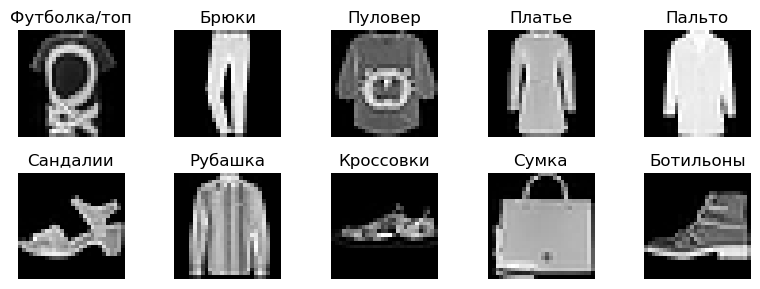

In [5]:
# Классы FashionMNIST
classes = ['Футболка/топ', 'Брюки', 'Пуловер', 'Платье', 'Пальто',
           'Сандалии', 'Рубашка', 'Кроссовки', 'Сумка', 'Ботильоны']

# Создаем словарь для хранения индексов изображений по классам
class_indices = {i: [] for i in range(len(classes))}

# Заполняем словарь индексами
for idx in range(len(train_dataset)):
    _, label = train_dataset[idx]
    class_indices[label].append(idx)

# Вывод по одному случайному изображению из каждого класса
fig, axes = plt.subplots(2, 5, figsize=(8, 3))  # 2 строки, 5 столбцов
axes = axes.flatten()  # Преобразуем в одномерный массив

for i, ax in enumerate(axes):
    # Получаем случайный индекс из текущего класса
    random_idx = random.choice(class_indices[i])
    img, label = train_dataset[random_idx]
    
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# train_dataset[0][0].shape

## Создание модели и определение параметров

In [7]:
# Определение архитектуры нейронной сети
class Network(torch.nn.Module):
    def __init__(self, X_size, y_size):
        super(Network, self).__init__()   

        # Последовательная модель из слоев
        self.sequental = torch.nn.Sequential(
            torch.nn.Flatten(),   

            # Полносвязный слой с нормализацией и активацией
            torch.nn.Linear(X_size, 256),  
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),     

            # Скрытый слой с регуляризацией
            torch.nn.Linear(256, 128), 
            torch.nn.Dropout(p=0.7), 
            torch.nn.ReLU(),      

            # Слой сжатия признакового пространства
            torch.nn.Linear(128, 64),                  
            torch.nn.BatchNorm1d(64), 
            torch.nn.ReLU(),

            # Выходной слой классификации
            torch.nn.Linear(64, y_size)
        )
    
    def forward(self, x):
        return self.sequental(x)

In [8]:
# Высление размера входного вектора
# Для одной картинки из train_dataset:
image_tensor, _ = train_dataset[0]  # получаем первый элемент датасета
dimension = image_tensor.numel()    # 1*28*28 = 784
X_size = dimension
y_size = len(classes)

# Нейронная сеть
model = Network(
    X_size,
    y_size
)

model = model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [9]:
# Настройка гиперпараметров обучения
num_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=.0001, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()
BATCH_SIZE=256

## Обучение

In [10]:
def train_model():
    # Инииализация переменных для ранней остановки
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 3  # Количество эпох для ранней остановки

    # Списки для хранения потерь
    train_losses = []
    val_losses = []
    val_accuracy = [] # и точности
    
    for epoch in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., 0.
        start=time.time()

        # Обучение
        model.train()
        for X, y in train:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Валидация
        model.eval()  # Переключение в режим оценки
        val_loss = 0.0
        val_acc = 0.0
        total_samples = 0
        with torch.no_grad():  # Отключение вычисления градиентов
            for X_val, y_val in val:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                val_l = criterion(y_pred, y_val)
                val_loss += val_l.item() * X_val.size(0)
                
                # Считаем точность
                preds = y_pred.argmax(dim=1)
                correct = (preds == y_val).sum().item()
                val_acc += correct
                total_samples += y_val.size(0)

        val_loss /= total_samples  # Средний лосс на весь датасет
        val_acc /= total_samples   # Доля правильных ответов

        train_losses.append(loss.item())
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)

        # Ранняя остановка
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Сохранение лучшей модели
        else:
            patience_counter += 1
        
        # Вывод статистики каждой эпохи
        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%')
        
        if patience_counter >= patience and epoch+1 < num_epochs:
            print("Early stopping!")
            break

    # Загрузка лучших весов модели
    model.load_state_dict(torch.load('best_model.pth'))

    return train_losses, val_losses, val_accuracy

In [11]:
# Обучение
train_losses, val_losses, val_acc = train_model()

Epoch 1, Train Loss: 1.2238, Val Loss: 1.0834, Val Acc: 77.96%
Epoch 2, Train Loss: 0.8488, Val Loss: 0.7433, Val Acc: 82.32%
Epoch 3, Train Loss: 0.6954, Val Loss: 0.5804, Val Acc: 84.20%
Epoch 4, Train Loss: 0.5697, Val Loss: 0.4978, Val Acc: 85.01%
Epoch 5, Train Loss: 0.5203, Val Loss: 0.4490, Val Acc: 85.61%
Epoch 6, Train Loss: 0.4773, Val Loss: 0.4190, Val Acc: 86.00%
Epoch 7, Train Loss: 0.4064, Val Loss: 0.3985, Val Acc: 86.41%
Epoch 8, Train Loss: 0.3685, Val Loss: 0.3831, Val Acc: 86.87%
Epoch 9, Train Loss: 0.3571, Val Loss: 0.3742, Val Acc: 86.99%
Epoch 10, Train Loss: 0.3060, Val Loss: 0.3659, Val Acc: 87.28%
Epoch 11, Train Loss: 0.3430, Val Loss: 0.3591, Val Acc: 87.47%
Epoch 12, Train Loss: 0.3235, Val Loss: 0.3532, Val Acc: 87.46%
Epoch 13, Train Loss: 0.2844, Val Loss: 0.3459, Val Acc: 87.77%
Epoch 14, Train Loss: 0.2375, Val Loss: 0.3440, Val Acc: 87.89%
Epoch 15, Train Loss: 0.2896, Val Loss: 0.3357, Val Acc: 88.04%
Epoch 16, Train Loss: 0.2875, Val Loss: 0.3398, V

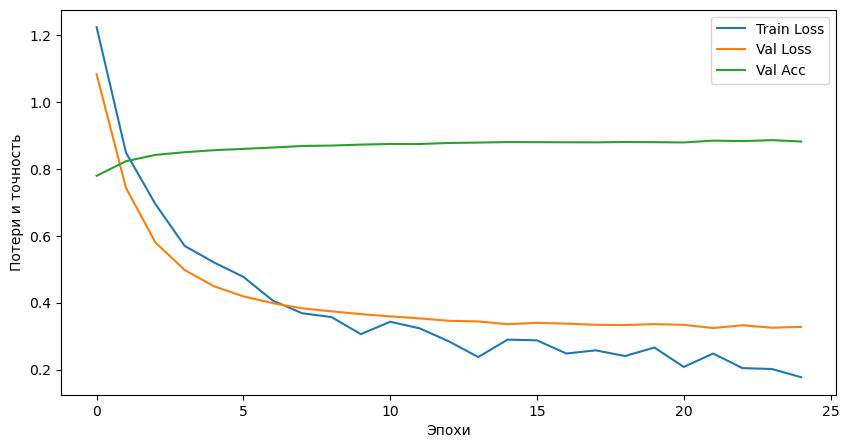

In [12]:
# График потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Эпохи')
plt.ylabel('Потери и точность')
plt.legend()
plt.show()


Image Info:
- размер рисунка: torch.Size([1, 28, 28])
- истина:         Ботильоны (9)
- предсказание:   Ботильоны (9)
- уверенность:    99.94%



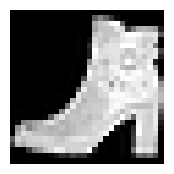

In [14]:
# Выбираем случайную картинку из валидационного набора
index = torch.randint(0, len(test_dataset), (1,)).item()
image, true_label = test_dataset[index]
image = image.unsqueeze(0).to(device)  # Добавляем batch dimension и переносим на устройство

# Делаем предсказание
model.eval()
with torch.no_grad():
    output = model(image)
predicted_label = torch.argmax(output, dim=1).item()

# Визуализация
plt.figure(figsize=(2, 2))
plt.imshow(image.cpu().squeeze().numpy(), cmap='gray' if image.shape[1] == 1 else None)
# plt.title(f"True: {classes[true_label]}\nPredicted: {classes[predicted_label]}", fontsize=12)
plt.axis('off')

# Добавляем описание
description = f"""
Image Info:
- размер рисунка: {test_dataset[index][0].shape}
- истина:         {classes[true_label]} ({true_label})
- предсказание:   {classes[predicted_label]} ({predicted_label})
- уверенность:    {torch.max(torch.softmax(output, dim=1)).item():.2%}
"""

print(description)
plt.show()